In [2]:
import torchvision
import torchvision.transforms as T

from tqdm.notebook import tqdm

from torch.utils.data import DataLoader, Dataset, Subset
import torch
import matplotlib.pyplot as plt

import numpy as np
import PIL.Image as Image

import pandas as pd

from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import torch.nn as nn

In [93]:
split = 0.8

n = 50000

features = 32 * 32
classes = 10

batch_size = 128

In [4]:
def move_to_classes():
    import shutil
    
    label_dataframe = pd.read_csv('data/trainLabels.csv')
    label = label_dataframe.pop('label')

    label_keys = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
    #uncommit to create class folders
    #for d in label_keys:
    #    os.mkdir(f'data/train_labeled/{d}')
    
    for i in range(1, 50000 + 1):
        source_path = f'data/train/class1/{i}.png'

        new_folder = label[i - 1]
        new_path = f'data/train_labeled/{new_folder}'

        shutil.move(source_path, new_path)

    return None

In [5]:
try:
    move_to_classes()
except:
    print('has already moved!')

has already moved!


In [70]:
def load_dataset(batch_size, a, b, split):
    data_path = 'data/train'
    new_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        #transform=T.Compose([T.ToTensor()])
    )
    
    train_dataset, test_dataset = random_split(new_dataset, [40000, 10000])
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )
    return train_loader, test_loader

In [71]:
train_loader, test_loader = load_dataset(batch_size, a, b, split)

In [98]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)

        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = 1)
        self.lin4 = nn.Linear(144, 144)

        self.bn1 = nn.BatchNorm2d(8)
        #self.pool = nn.MaxPool2d(kernel_size=2,2, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.lin1 = nn.Linear(16 * 6 * 6, 144)
        self.drp1 = nn.Dropout(0.3)
        self.lin2 = nn.Linear(144, 100)
        self.lin3 = nn.Linear(100, classes)

    def skip(self, x):
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(self.conv3(x), 1)

        #print(x.shape)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.lin4(x))
        return x

    def forward(self, x):       
        x = F.max_pool2d(self.conv1(x), (2, 2))
        x = F.max_pool2d(self.conv2(x), 2)

        s = self.skip(x)
        
        x = x.view(x.shape[0], -1)
        x = F.relu(self.lin1(x))
        
        x = x + s
        
        x = F.relu(self.lin2(x))
        x = F.relu(self.drp1(x))
        x = F.softmax(self.lin3(x), dim=1)
        
        return x

def check(loader, n, split, isTrain, model):
    acc = torch.zeros(11)
    eta = 1 - split
    k = 0
    if isTrain:
        eta = split
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            r = y.shape[0]
            
            pred = model(x)
            
            for i in range(r):
                if pred[i].argmax() == y[i]:
                    k += 1
    #print(k)
    
    return k * 100 / n / eta

In [82]:
alpha = 3e-4

model = Net()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=alpha)

history = []
acc = []
epochs = 50

In [89]:
epochs = 4000
for g in optim.param_groups:
    g['lr'] = 5e-5
acc_train = []
acc_test = []

history = []
for epoch in range(epochs):
    for x_batch, y_batch in tqdm(train_loader):
        y_pred = model(x_batch)
    
        loss = loss_fn(y_pred, y_batch)
        #train_acc = torch.sum(y_pred == y_batch)
        optim.zero_grad()
        loss.backward()
        optim.step()

    
    acc_test.append(check(test_loader, a, b, split, False, model))
    print(f'acc on test[{epoch}]: {acc_test[epoch]}%')

    #acc_train.append(check(train_loader, a, b, split, True, model))
    #print(f'acc on train[{epoch}]: {acc_train[epoch]}%')
        
    history.append(loss.item())
        
    print(f'Epoch: {epoch + 1}/{epochs}; loss: {loss.item()};') 

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[0]: 62.81%
Epoch: 1/4000; loss: 1.6725035905838013;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[1]: 62.41%
Epoch: 2/4000; loss: 1.7647509574890137;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[2]: 62.38%
Epoch: 3/4000; loss: 1.5899908542633057;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[3]: 62.44%
Epoch: 4/4000; loss: 1.6813969612121582;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[4]: 62.25%
Epoch: 5/4000; loss: 1.6476998329162598;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[5]: 62.6%
Epoch: 6/4000; loss: 1.5647729635238647;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[6]: 62.77%
Epoch: 7/4000; loss: 1.6843883991241455;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[7]: 62.09%
Epoch: 8/4000; loss: 1.656733512878418;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[8]: 62.45%
Epoch: 9/4000; loss: 1.6212224960327148;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[9]: 62.61%
Epoch: 10/4000; loss: 1.5450477600097656;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[10]: 62.23%
Epoch: 11/4000; loss: 1.583208680152893;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[11]: 62.45%
Epoch: 12/4000; loss: 1.6781871318817139;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[12]: 62.87%
Epoch: 13/4000; loss: 1.6030240058898926;


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

acc on test[13]: 62.39%
Epoch: 14/4000; loss: 1.6752523183822632;


  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

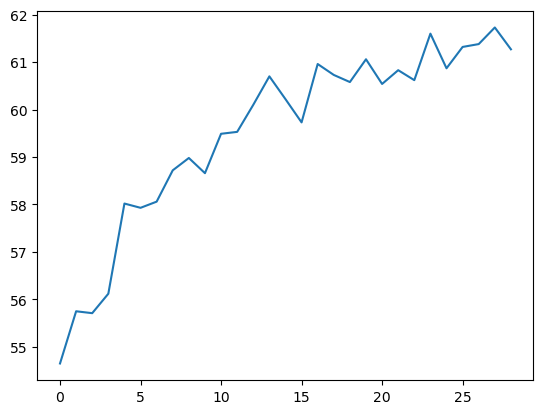

In [86]:
plt.plot(acc_test)

In [99]:
check(train_loader, n, split, True, model)

  0%|          | 0/313 [00:00<?, ?it/s]

82.375